# BIOINFORMATICS - PROJECT 2

#### Alessandro Taglieri, Davide Zingaro, Yao Appeti

### Import libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from smallworld.draw import draw_network

import random
import infomap
import random
import pyedflib
from collections import defaultdict
import json
import connectivipy as cp
np.random.seed(1861402)
import time
import louvain
import igraph
from igraph import *
from igraph import Graph as igraphGraph

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.


load data: R01 is recorded during eyes-open (EO) resting state; R02 is recorded during eyes-closed (EC) resting state.

In [2]:
path = 'data/'

file_name = 'S038R01.edf'  #eyes-open (EO)
file_name2 = 'S038R02.edf' #eyes-closed (EC)



In [3]:
def read_data_file(file):
    f = pyedflib.EdfReader(file)
    
    n = f.signals_in_file
    #signal_labels = f.getSignalLabels()
    signal_labels = [name.replace(".","") for name in f.getSignalLabels()]
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    #data=pd.DataFrame(sigbufs).T
    #data.columns=signal_labels
    return signal_labels,sigbufs

In [4]:
labels, data = read_data_file(path+file_name)
labels2, data2 = read_data_file(path+file_name2)

# 1.1  (Mandatory)

In [5]:
#method that allow to estimate functional brain conectivity using DTF estimator
def estimator_DTF(data, freq):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    dtf = cp.conn.dtf_fun(ar, vr, fs=10, resolution=100, generalized=False)[freq,:,:]
    return dtf

#method that allow to estimate functional brain conectivity using PDC estimator
def estimator_PDC(data,freq):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    pdc = cp.conn.pdc_fun(ar, vr, fs=10, resolution=100, generalized=False)[freq,:,:]
    return pdc

def find_T_est_1(significance,density):  
    
    total_num = significance.shape[0]*(significance.shape[1])
    k = significance.shape[0]
    n = int( density*total_num+k)
    T = sorted(significance.flatten())[-n]
    return T

def build_adj(est, T):
    adj = 1*(est>T)
    return adj

In [6]:
#method that allows to build graph
def build_graph(adj,labels):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    
    Edges = [(labels[idx_i[i]],labels[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    our_graph=nx.DiGraph()
    our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
   
    plt.draw()
    plt.show()
    return our_graph


/opt/anaconda3/lib/python3.7/site-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


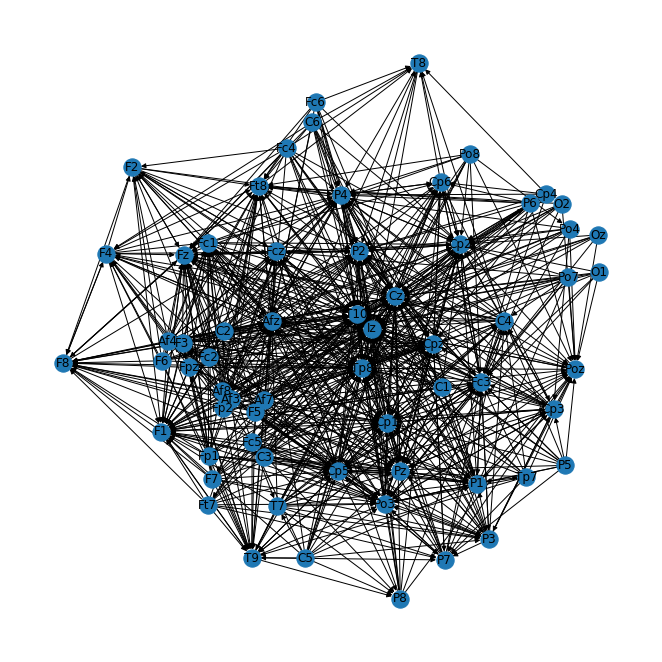

In [7]:
#build graph for DTF estimator on eyes open
dtf= estimator_DTF(data,9)
T= find_T_est_1(dtf,0.2)
adjj= build_adj(dtf, T)
graph_DTF_eo= build_graph(adjj,labels)

In [8]:
len(graph_DTF_eo.edges)/(64*63)

0.20287698412698413

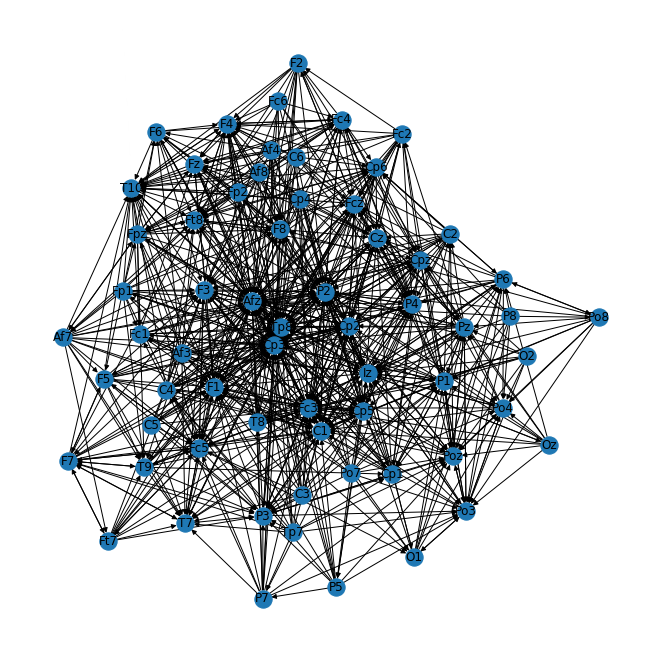

In [9]:
#build graph for DTF estimator on eyes closed
dtf2= estimator_DTF(data2,9)
T= find_T_est_1(dtf2,0.2)
adjj2= build_adj(dtf2, T)
graph_DTF_ec= build_graph(adjj2,labels2)

In [10]:
len(graph_DTF_ec.edges)/(64*63)

0.20287698412698413

In [11]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

# 1.2

False


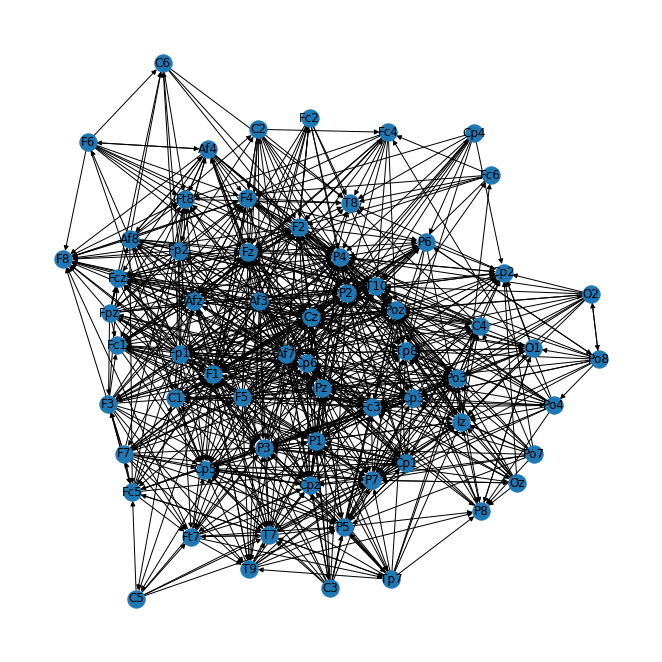

Name: 
Type: DiGraph
Number of nodes: 64
Number of edges: 818
Average in degree:  12.7812
Average out degree:  12.7812


In [12]:
pdc= estimator_PDC(data,9) # eyes opened

T= find_T_est_1(pdc,0.2)
adjj= build_adj(pdc, T)
print(check_symmetric(adjj))
graph_PDC_eo= build_graph(adjj,labels)
print (nx.info(graph_PDC_eo))

False


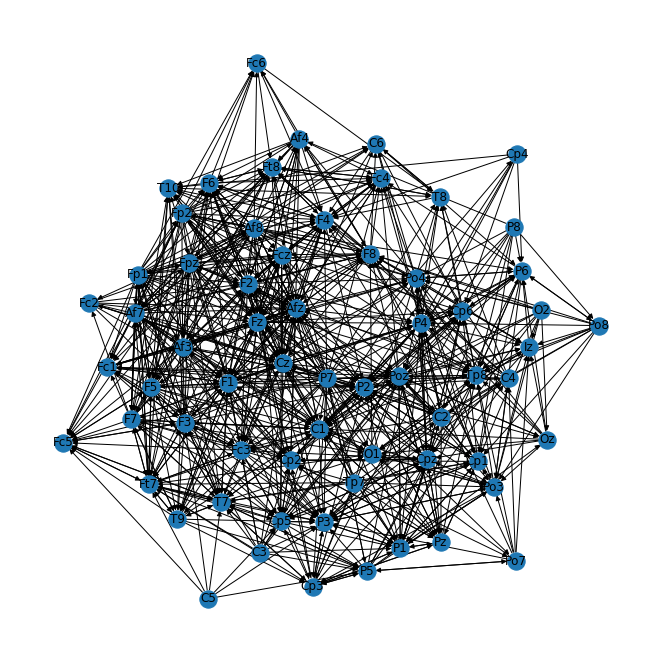

In [13]:
pdc2= estimator_PDC(data2,9) # eyes closed

T= find_T_est_1(pdc2,0.2)
adjj3= build_adj(pdc2, T)
print(check_symmetric(adjj3))
graph_PDC_ec= build_graph(adjj3,labels2)

# 1.4

In [14]:
def estimation_1(data, nrepp):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    dtf_values = dt.conn('dtf')
    dtf_significance = dt.significance(Nrep=nrepp, alpha=0.05)
    return dtf_significance

In [15]:
sub_labels=['Fp1','Fp2','F7','F3','Fz','F4','F8','T7','C3','Cz','C4','T8','P7','P3','Pz','P4','P8','O1',\
            'O2']
idx_labels=[labels.index(sub_labels[i]) for i in range(19)]
sub_data = data[idx_labels,]

In [16]:
sign_19= estimation_1(sub_data, 100)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


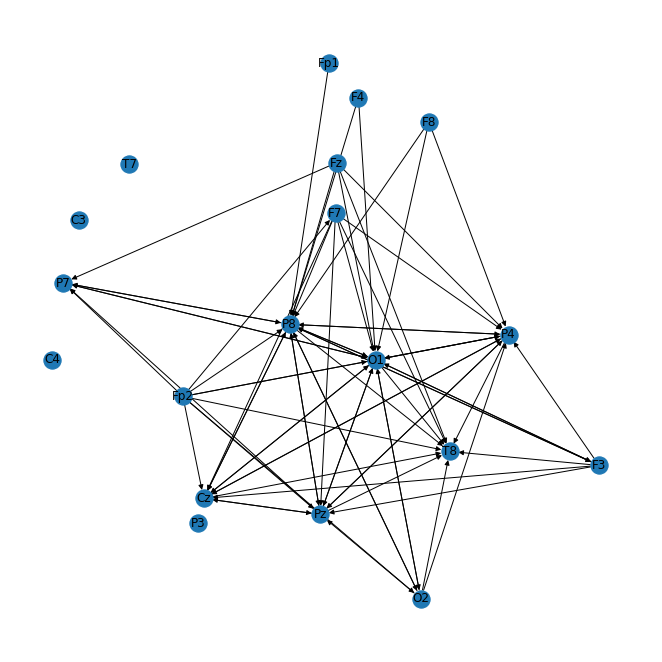

In [17]:
T= find_T_est_1(sign_19,0.2)
adjj19= build_adj(sign_19, T)
graph_DTF_19c_eo = build_graph(adjj19,sub_labels)

In [18]:
len(graph_DTF_19c_eo.edges)/(19*18)

0.20760233918128654

In [19]:
idx_labels=[labels2.index(sub_labels[i]) for i in range(19)]
sub_data2 = data2[idx_labels,]

In [20]:
sign_19_2= estimation_1(sub_data2, 100) 

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


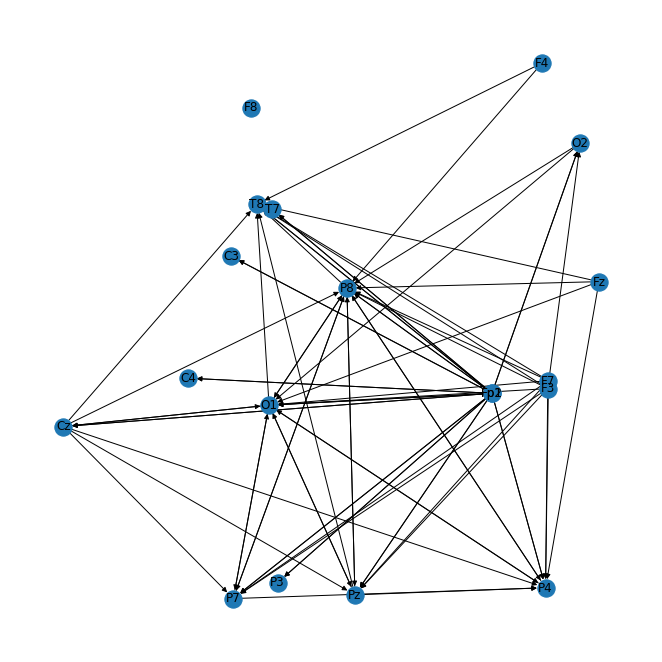

In [21]:
T= find_T_est_1(sign_19_2,0.2)
adjj19_2= build_adj(sign_19_2, T)
graph_DTF_19c_ec= build_graph(adjj19_2,sub_labels)

In [22]:
len(graph_DTF_19c_ec.edges)/(19*18)

0.20760233918128654

# 1.5

In [23]:
#load channel_locations.txt
chanel_locations = pd.read_table('data/channel_locations.txt', sep=' ', usecols=['label','x','y'])
chanel_locations['label']=chanel_locations['label'].str.replace('.','')

In [24]:
def build_graph_1_5(adj,nodes,labels,coord):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    our_graph=nx.DiGraph()
    for i in range(len(labels)):
        our_graph.add_node(labels[i],
                          pos=(coord[coord['label']==labels[i]]['x'].values.item(0),
                              coord[coord['label']==labels[i]]['y'].values.item(0)))
    Edges = [(nodes[idx_i[i]],nodes[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    
    #our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos=nx.get_node_attributes(our_graph,'pos')
    #pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

False


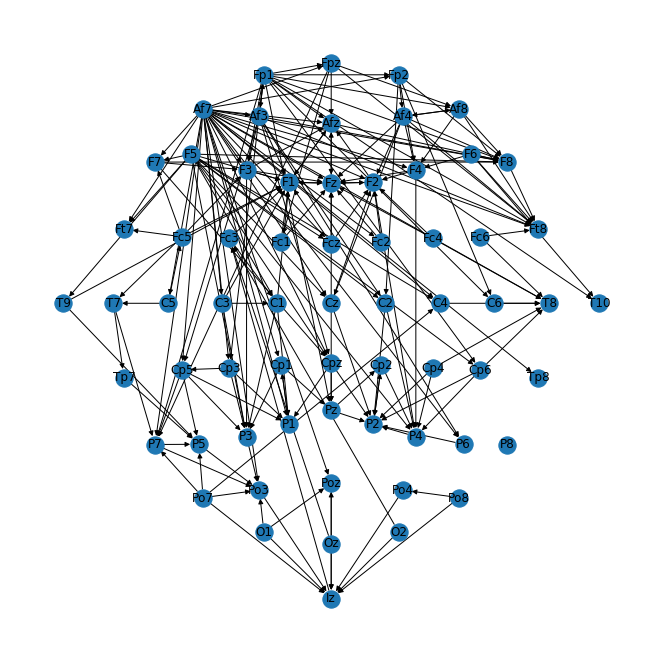

In [25]:
T= find_T_est_1(pdc,0.05)
adjj005= build_adj(pdc, T)
print(check_symmetric(adjj005))
graph_1_5= build_graph_1_5(adjj005,labels,labels,chanel_locations)

False


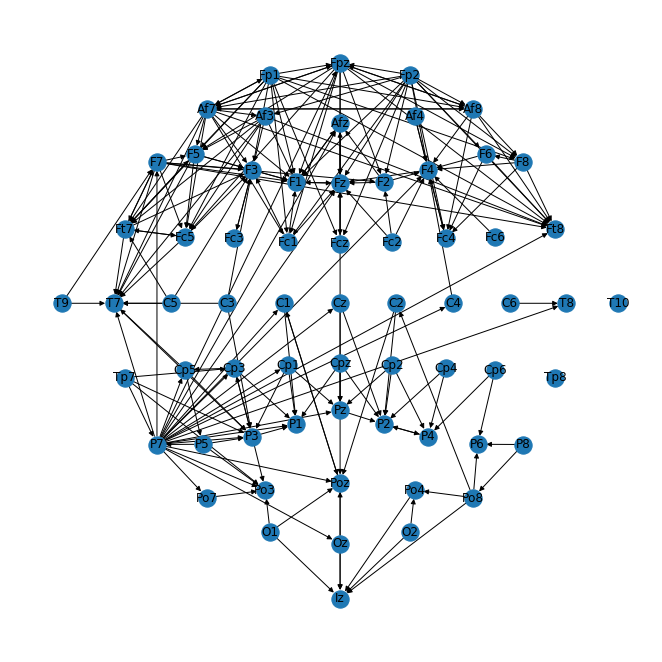

In [26]:
T= find_T_est_1(pdc2,0.05)
adjj005= build_adj(pdc2, T)
print(check_symmetric(adjj005))
graph_1_5_b= build_graph_1_5(adjj005,labels,labels,chanel_locations)

In [27]:
len(graph_1_5.edges)/(64*63)

0.050347222222222224

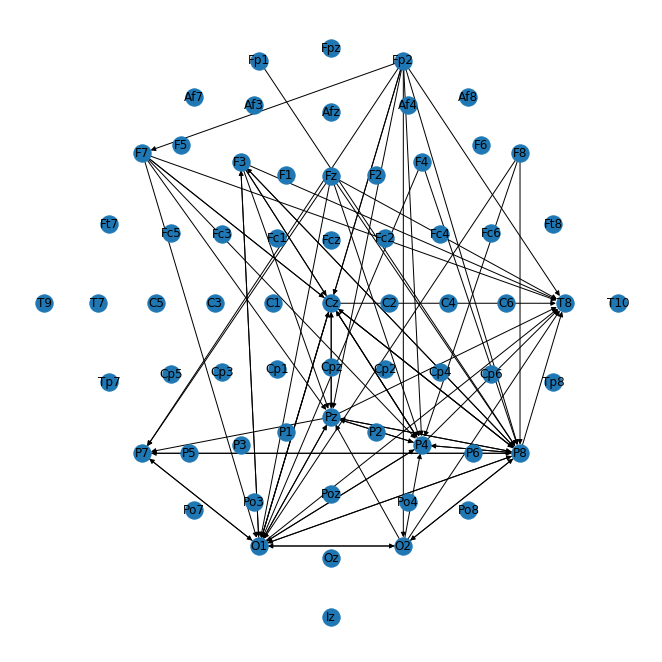

In [28]:
gg8= build_graph_1_5(adjj19,sub_labels,labels,chanel_locations)

In [29]:
len(gg8.edges)/(64*63)

0.017609126984126984

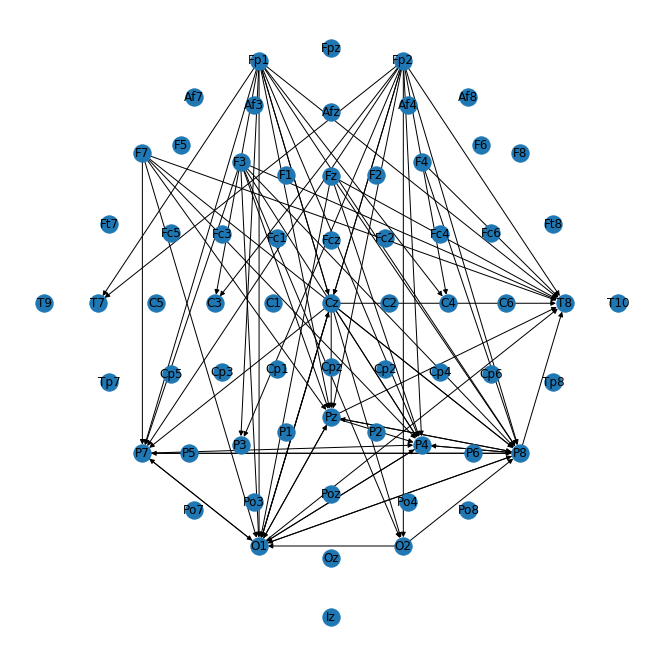

In [30]:
gg8_2= build_graph_1_5(adjj19_2,sub_labels,labels,chanel_locations)

In [31]:
len(gg8_2.edges)/(64*63)

0.017609126984126984

# 2.1 (Mandatory)

In [32]:
#global clustering coefficient, is avg of CC among all nodes
def gloabal_clustering_coefficient(graph):
    CC=[]
    all_edg = set()
    for node in graph.nodes:
        #print(node)
        neighbors = (set(graph.successors(node))).union(set(graph.predecessors(node)))
        #print(neighbors)
        e=0
        neighbors.add(node)
        edges = set(graph.in_edges(node))
        edges= edges.union(set(graph.out_edges(node)))
        for ne in neighbors:
            edges= edges.union(set(graph.in_edges(ne)))
            edges = edges.union(set(graph.out_edges(ne)))
            
            #print("edges")
            #print(edges)
        for edg in edges:
            x, y = edg

            if (x in neighbors) and (y in neighbors):
                e=e+1
                    #print(1)
            #all_edg = all_edg.union(edges)
        #print(e)
        k = len(neighbors)*(len(neighbors)-1)
        #print(k)
        CC.append(e/(k))
    return np.sum(CC)/len(CC)

In [33]:
(gloabal_clustering_coefficient(graph_DTF_eo)) #eyes-open (EO)

0.4096549614681534

In [34]:
(gloabal_clustering_coefficient(graph_DTF_ec)) #eyes-closed (EC)

0.41073416160929105

In [35]:
#global/average path length
def avg_path(graph):
    l=[]
    for node in graph:
        # find all the descendants for each node
        descendants = set(nx.shortest_path_length(graph, node)) - set([node])
        e=0
        for x in descendants:
            # shortest path between two vertices
            s_p = nx.shortest_path_length(graph,source=node,target=x)
            e=e+s_p
        l.append(e)
        e_t = sum(l)
        k = len(graph.nodes())*(len(graph.nodes())-1)
    return (e_t/k)

In [36]:
#the average path length is:
avg_path(graph_DTF_eo) #eyes-open (EO)

0.8432539682539683

In [37]:
avg_path(graph_DTF_ec) #eyes-closed (EC)

1.5562996031746033

In [38]:
#in-degree
def in_degree(graph):
    in_d = graph.in_degree()
    in_d_10 = sorted(graph.in_degree(), key = lambda x: x[1], reverse = True)[:10]
    return(in_d, in_d_10)

In [39]:
#highest 10 channels for in-degree

in_degree_eo = pd.DataFrame(in_degree(graph_DTF_eo)[1]) #eyes-open (EO)

in_degree_eo.columns = ['Node', 'In-Degree'] #rename columns
in_degree_eo.style.hide_index() #hide row index

In [40]:
#highest 10 channels for in-degree
in_degree_ec = pd.DataFrame(in_degree(graph_DTF_ec)[1]) #eyes-closed (EC)

in_degree_ec.columns = ['Node', 'In-Degree'] #rename columns
in_degree_ec.style.hide_index() #hide row index

In [41]:
#out-degree
def out_degree(graph):
    out_d = graph.out_degree()
    out_d_10 = sorted(graph.out_degree(), key = lambda x: x[1], reverse = True)[:10]
    return(out_d, out_d_10)

In [42]:
#highest 10 channels for out-degree
out_degree_eo = pd.DataFrame(out_degree(graph_DTF_eo)[1]) #eyes-open (EO)

out_degree_eo.columns = ['Node', 'Out-Degree'] #rename columns
out_degree_eo.style.hide_index() #hide row index

In [43]:
#highest 10 channels for out-degree
out_degree_ec = pd.DataFrame(out_degree(graph_DTF_ec)[1]) #eyes-closed (EC)

out_degree_ec.columns = ['Node', 'Out-Degree'] #rename columns
out_degree_ec.style.hide_index() #hide row index

In [44]:
#degree
def degree(graph):
    d = graph.degree()
    d_10 = sorted(graph.degree(), key = lambda x: x[1], reverse = True)[:10]
    return(d, d_10)

In [45]:
#highest 10 channels for degree
degree_eo = pd.DataFrame(degree(graph_DTF_eo)[1]) #eyes-open (EO)

degree_eo.columns = ['Node', 'Degree'] #rename columns
degree_eo.style.hide_index() #hide row index

In [46]:
#highest 10 channels for degree
degree_ec = pd.DataFrame(degree(graph_DTF_ec)[1]) #eyes-closed (EC)

degree_ec.columns = ['Node', 'Degree'] #rename columns
degree_ec.style.hide_index() #hide row index

# 2.2

In [47]:
def small_world(graph):
    #graph average degree
    degree_k = [item[1] for item in list(graph.in_degree)]
    k_average = round(sum(degree_k)/len(degree_k))
    
    N = len(graph.nodes)
    betas = [0, 0.25, 1.0]
    labels_sw = [ r'Regular: $\beta=0$', r'Small-world: $\beta=0.25$', r'Random: $\beta=1$']
    
    focal_node = 0

    fig, ax = plt.subplots(1,3,figsize=(9,3))
    
    # scan beta values
    for ib, beta in enumerate(betas):

        # generate small-world graphs and draw
        G = nx.watts_strogatz_graph(N, k_average, beta, seed=None)
        GD = G.to_directed()
        draw_network(GD,k_average,focal_node=focal_node,ax=ax[ib])
        print('Directed graph:', GD.is_directed())

        ax[ib].set_title(labels_sw[ib],fontsize=11)

    # show
    plt.subplots_adjust(wspace=0.3)
    plt.show()

Directed graph: True
Directed graph: True
Directed graph: True


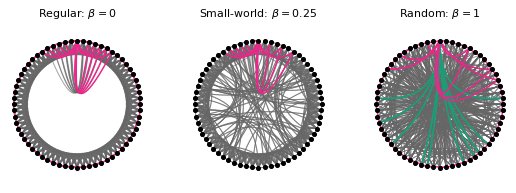

In [48]:
small_world(graph_DTF_eo)

Directed graph: True
Directed graph: True
Directed graph: True


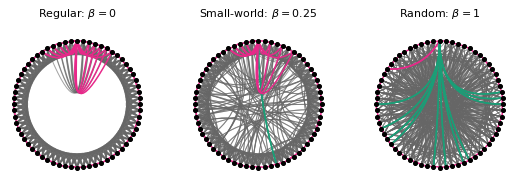

In [49]:
small_world(graph_DTF_ec) #eyes-closed (EC)

In [50]:
def small_world_sigma(graph):
    #create a directed random graph with same nodes and edges of our graph
    random_graph= nx.gnm_random_graph(len(graph.nodes), len(graph.edges), directed=True)
    
    #compare average clustering coefficients
    AC_sigma = gloabal_clustering_coefficient(graph)/gloabal_clustering_coefficient(random_graph)
    #compare average path lengths
    AP_sigma = avg_path(graph)/avg_path(random_graph)
    
    sigma = AC_sigma/AP_sigma
    
    return sigma

In [51]:
#sigma>1 it is a small-world network
small_world_sigma(graph_DTF_eo) #eyes-open (EO)

3.865350224811356

In [52]:
small_world_sigma(graph_DTF_ec) #eyes-closed (EC)

2.1651631466300363

# 2.3. 

In [53]:
#global clustering coefficient with PDC
gloabal_clustering_coefficient(graph_PDC_eo) #eyes-open (EO)

0.326237732581205

In [54]:
gloabal_clustering_coefficient(graph_PDC_ec) #eyes-closed (EC)

0.36055832554159606

In [55]:
#average path length with PDC
avg_path(graph_PDC_eo) #eyes-open (EO)

2.6731150793650795

In [56]:
avg_path(graph_PDC_ec) #eyes-closed (EC)

1.9871031746031746

# 2.5

In [57]:
def build_graph_degree(adj,nodes,nodes_10,labels,coord):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    our_graph=nx.DiGraph()
    color_map = []
    for i in range(len(labels)):
        if i in [labels.index(nodes_10[i]) for i in range(10)]:
            color_map.append('cyan')
        else:
            color_map.append('red')    
        our_graph.add_node(labels[i],
                          pos=(coord[coord['label']==labels[i]]['x'].values.item(0),
                              coord[coord['label']==labels[i]]['y'].values.item(0)))
    Edges = [(nodes[idx_i[i]],nodes[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    
    #our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos=nx.get_node_attributes(our_graph,'pos')
    #pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,node_color = color_map,with_labels=True)
    plt.draw()
    plt.show()
    return our_graph

def local_indegree(graph):
    indegree_channels = [item[0] for item in list(in_degree(graph)[0])]
    idx_indegree = [labels.index(indegree_channels[i]) for i in range(64)]
    indegree_channels_10 = [item[0] for item in list(in_degree(graph)[1])]
    idx_indegree_10 = [labels.index(indegree_channels[i]) for i in range(10)]
    sub_indegree = data[idx_indegree,]
    return indegree_channels, indegree_channels_10, sub_indegree

def local_outdegree(graph):
    outdegree_channels = [item[0] for item in list(out_degree(graph)[0])]
    idx_outdegree = [labels.index(outdegree_channels[i]) for i in range(64)]
    outdegree_channels_10 = [item[0] for item in list(out_degree(graph)[1])]
    idx_outdegree_10 = [labels.index(outdegree_channels[i]) for i in range(10)]
    sub_outdegree = data[idx_outdegree,]
    return outdegree_channels, outdegree_channels_10, sub_outdegree

def local_degree(graph):
    degree_channels = [item[0] for item in list(degree(graph)[0])]
    idx_degree = [labels.index(degree_channels[i]) for i in range(64)]
    degree_channels_10 = [item[0] for item in list(degree(graph)[1])]
    idx_degree_10 = [labels.index(degree_channels[i]) for i in range(10)]
    sub_degree = data[idx_degree,]
    return degree_channels, degree_channels_10, sub_degree

/opt/anaconda3/lib/python3.7/site-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


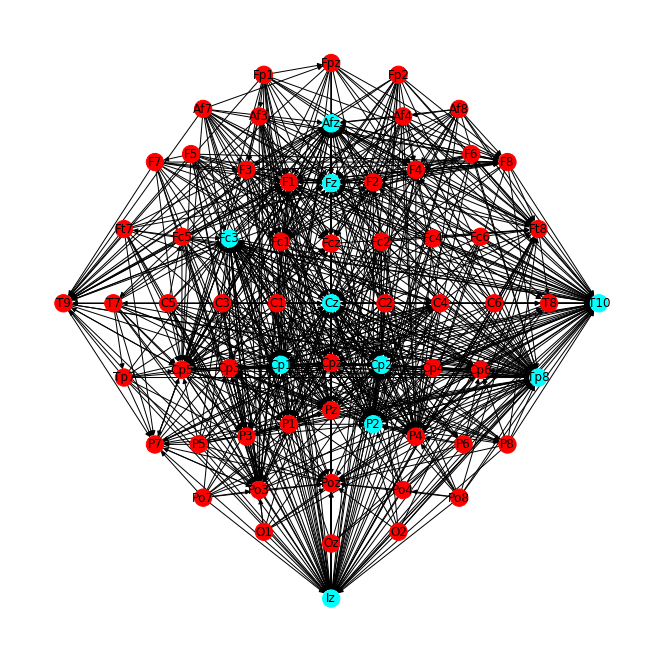

In [58]:
#eyes-open (EO)
#IN-DEGREE
in_channels, in_channels_10, s_indegree = local_indegree(graph_DTF_eo)
indegree_est = estimator_DTF(s_indegree, 9)
T = find_T_est_1(indegree_est,0.20)
adjj_indegree = build_adj(indegree_est, T)
gg_local_indegree = build_graph_degree(adjj_indegree,in_channels,in_channels_10,labels,chanel_locations)

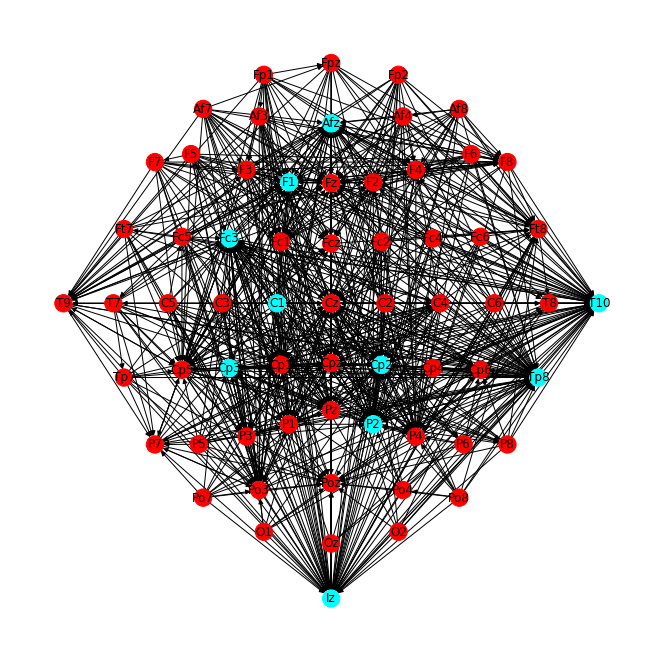

In [59]:
#eyes-closed (EC)
#IN-DEGREE
in_channels, in_channels_10, s_indegree = local_indegree(graph_DTF_ec)
indegree_est = estimator_DTF(s_indegree, 9)
T = find_T_est_1(indegree_est,0.20)
adjj_indegree = build_adj(indegree_est, T)
gg_local_indegree = build_graph_degree(adjj_indegree,in_channels,in_channels_10,labels,chanel_locations)

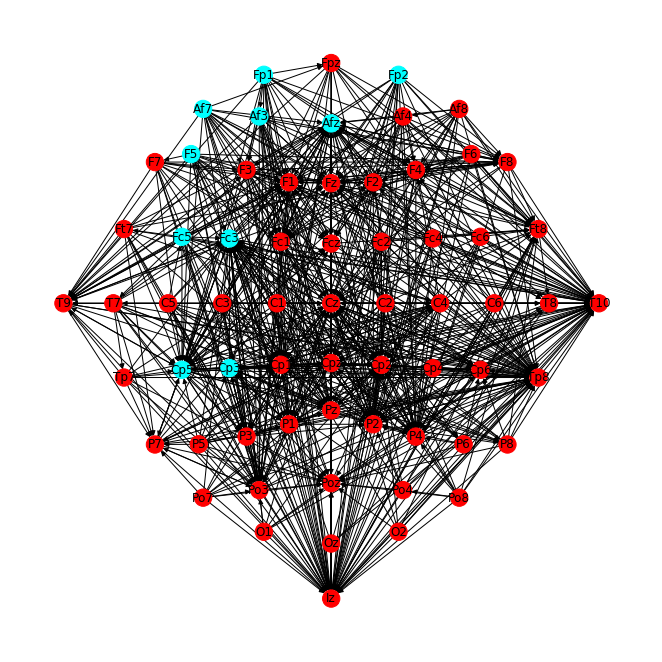

In [60]:
#eyes-open (EO)
#OUT-DEGREE
out_channels, out_channels_10, s_outdegree = local_outdegree(graph_DTF_eo)
outdegree_est = estimator_DTF(s_outdegree, 9)
T = find_T_est_1(outdegree_est,0.20)
adjj_outdegree = build_adj(outdegree_est, T)
gg_local_outdegree = build_graph_degree(adjj_outdegree,out_channels,out_channels_10,labels,chanel_locations)

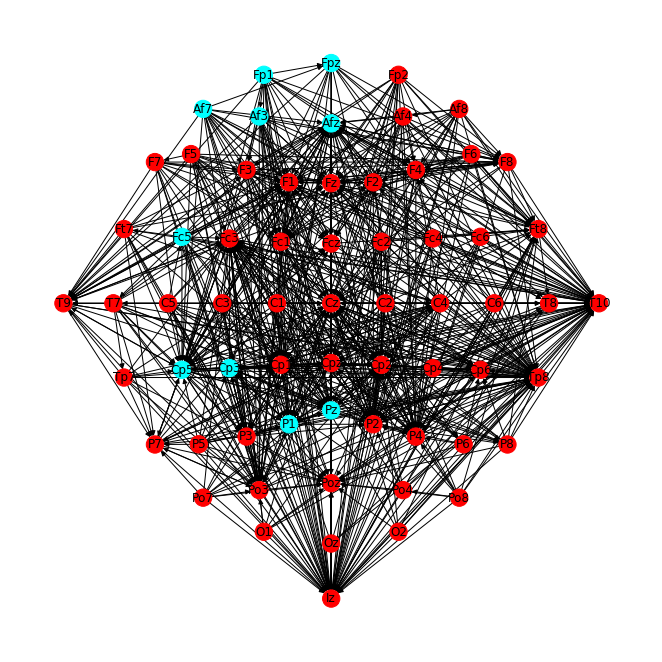

In [61]:
#eyes-closed (EC)
#OUT-DEGREE
out_channels, out_channels_10, s_outdegree = local_outdegree(graph_DTF_ec)
outdegree_est = estimator_DTF(s_outdegree, 9)
T = find_T_est_1(outdegree_est,0.20)
adjj_outdegree = build_adj(outdegree_est, T)
gg_local_outdegree = build_graph_degree(adjj_outdegree,out_channels,out_channels_10,labels,chanel_locations)

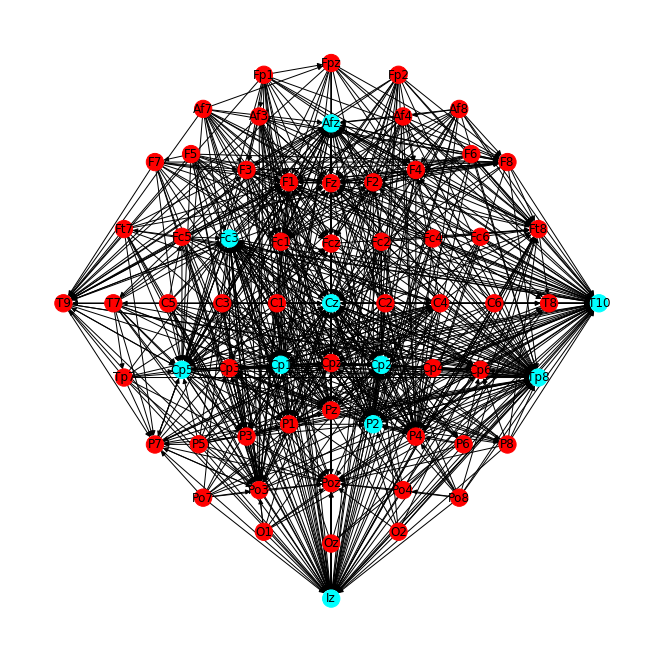

In [62]:
#eyes-open (EO)
#DEGREE
d_channels, d_channels_10, s_degree = local_degree(graph_DTF_eo)
degree_est = estimator_DTF(s_degree, 9)
T = find_T_est_1(degree_est,0.20)
adjj_degree = build_adj(degree_est, T)
gg_local_degree = build_graph_degree(adjj_degree,d_channels,d_channels_10,labels,chanel_locations)

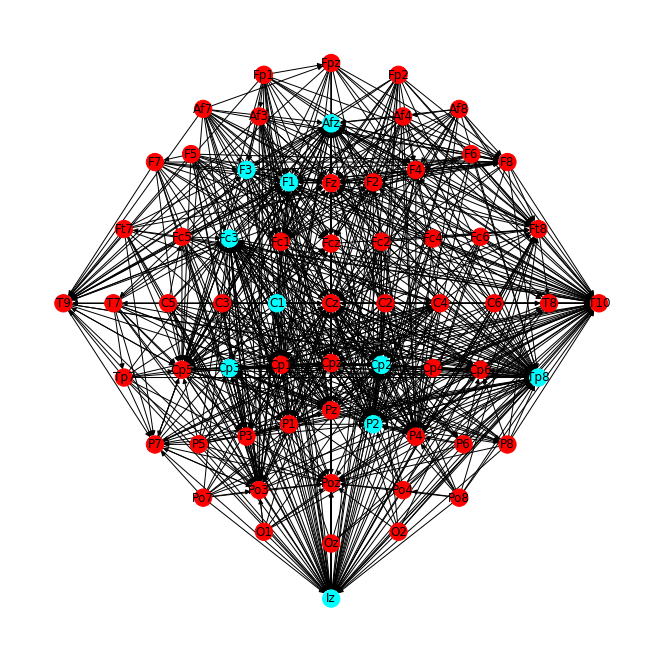

In [63]:
#eyes-closed (EC)
#DEGREE
d_channels, d_channels_10, s_degree = local_degree(graph_DTF_ec)
degree_est = estimator_DTF(s_degree, 9)
T = find_T_est_1(degree_est,0.20)
adjj_degree = build_adj(degree_est, T)
gg_local_degree = build_graph_degree(adjj_degree,d_channels,d_channels_10,labels,chanel_locations)

# 3.1 (Mandatory)

In [64]:
def get_frequence(graph):
    
    configs = ['A->B->C', 'A->B->C->A','A->B<-C','A->B<-C->A','A<-B->C', 'A<-B->C->A']
    
    conf1,conf2,conf22,conf222,conf_4,conf_5,conf_6 = set(),set(),set(),set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            for th in third_step:
                if th!=node:
                    conf1.add(tuple(sorted(set([node,sec,th])) ))
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == sec:
                            fifth = set(graph.successors(fourth))
                            for fi in fifth:
                                if node==fi:
                                    conf_6.add(tuple(sorted(set([node,sec,th,fourth,fi])) ))#(())
                        if fourth == node :
                            conf2.add(tuple(sorted(set([node,sec,th,fourth]))))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:

                                if fif==th:
                                    conf222.add(tuple(sorted(set([node,sec,th,fourth,fif]))))                            
                                    six = set(graph.successors(fif))
                                    for s in six:
                                        conf_4.add(tuple(sorted(set([node,sec,th,fourth,fif,s]))))
                                        if s==sec:
                                            sev = set(graph.successors(s))
                                            for se in sev:
                                                if se==node:
                                                    conf_5.add(tuple(sorted(set([node,sec,th,fourth,fif,s,se]))))
                        if fourth==sec:
                            conf22.add(tuple(sorted(set([node,sec,th,fourth]))))
    poss_confs={configs[0] : [len(conf1)]}
    poss_confs[configs[1]]=[len(conf2)]
    poss_confs['A->B->C->B']=[len(conf22)]
    poss_confs['A->B->C->A->C']=[len(conf222)]
    poss_confs['A->B->C->A->C->B']=[len(conf_4)]
    poss_confs['A->B->C->A->C->B->A']=[len(conf_5)]
    poss_confs['A->B->C->B->A']=[len(conf_6)]
    
    conf3, conf4, conf44 = set(),set(),set()      
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.predecessors(sec))
            
            for th in third_step:
                if th!=node:
                    conf3.add(tuple(sorted(set([node,sec,th])) ))  
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node:
                            conf4.add(tuple(sorted(set([node,sec,th,fourth]))))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif==th:
                                    conf44.add(tuple(sorted(set([node,sec,th,fourth,fif]))))
    poss_confs[configs[2]]=[len(conf3)]
    poss_confs[configs[3]]=[len(conf4)]
    poss_confs['A->B<-C->A->C']=[len(conf44)]
     
    conf5,conf6,conf7,conf8 = set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.predecessors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    conf5.add(tuple(sorted(set([node,sec,th])) ))
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node:
                            #conf6.add((node,sec,th,fourth))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == th:
                                    conf8.add(tuple(sorted(set([node,sec,th,fourth,fif]))))
                        if fourth==sec:
                            conf7.add(tuple(sorted(set([node,sec,th,fourth]))))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == node:
                                    conf6.add(tuple(sorted(set([node,sec,th,fourth,fif]))))
    poss_confs[configs[4]]=[len(conf5)]
    
    poss_confs['A<-B->C->B']=[len(conf7)]
    poss_confs['A<-B->C->A->C']=[len(conf8)]
    
    return poss_confs#,pics

In [65]:
res= get_frequence(graph_DTF_eo)
res2= get_frequence(graph_DTF_ec)

In [66]:
def sub_graphs(results_dict):
    results=[x for x in results_dict.keys() if results_dict[x][0]>0]
    number_of_colors = 15
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
    for i in range(len(results)):
        config = results[i]
        sub_graph = nx.DiGraph()
        sub_graph.add_nodes_from(['A','B','C'])
        for c  in range(len(config)):
            if config[c]=='>':
                sub_graph.add_edge(config[c-2],config[c+1])
            if config[c]=='<':
                sub_graph.add_edge(config[c+2],config[c-1])
        plt.figure(1,figsize=(2,2)) 
        nx.draw_networkx(sub_graph,node_color=random.choice(color),edge_color='b')
        plt.show()
        print(results_dict[config])



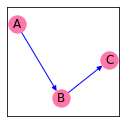

[6536]


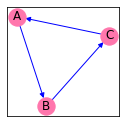

[376]


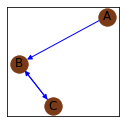

[2631]


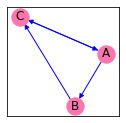

[371]


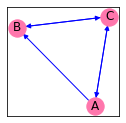

[3883]


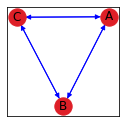

[58]


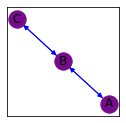

[355]


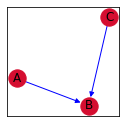

[11879]


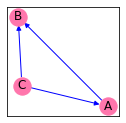

[3660]


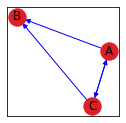

[516]


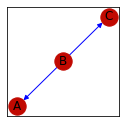

[4812]


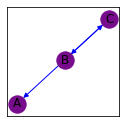

[900]


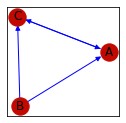

[1040]


In [67]:
sub_graphs(res)


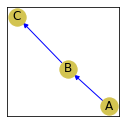

[7068]


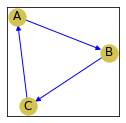

[651]


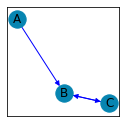

[3356]


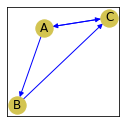

[616]


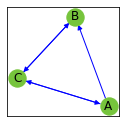

[7259]


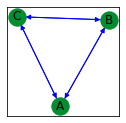

[72]


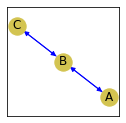

[578]


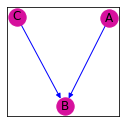

[9278]


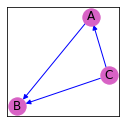

[3123]


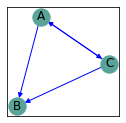

[649]


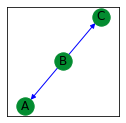

[4475]


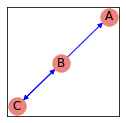

[1367]


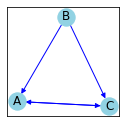

[1191]


In [68]:
sub_graphs(res2)

In [69]:
def rand_freq(dens):
    e =nx.erdos_renyi_graph(64,dens,directed=True)
    freq = get_frequence(e)
    for i in range(100):
        e =nx.erdos_renyi_graph(64,dens,directed=True)
        first = get_frequence(e)
        for x in first.keys():
            freq[x].append(first[x][0])
    freqmean_std=freq
    for f in freq.keys():
        freqmean_std[f]=(np.mean(freq[f]),np.std(freq[f]))
    return freqmean_std

In [70]:
r_g = rand_freq(0.2)

In [71]:
def get_z(real, rand_g):
    result = {k: v for k, v in real.items()}
    for x in result.keys():
        div = (rand_g[x][1]+0.001)
        result[x]=(real[x][0]-rand_g[x][0])/(div)
    return result

In [72]:
final_counts = pd.DataFrame(res).T
final_counts['1']=list(get_z(res,r_g).values())
final_counts.columns = ['N_real','Z']
final_counts

N_real          Z
A->B->C                6536  -3.300431
A->B->C->A              376  -3.902771
A->B->C->B             2631   5.199851
A->B->C->A->C           371   0.948536
A->B->C->A->C->B       3883  -0.477209
A->B->C->A->C->B->A      58  32.965606
A->B->C->B->A           355   3.750202
A->B<-C               11879  21.383659
A->B<-C->A             3660  12.901890
A->B<-C->A->C           516   9.396555
A<-B->C                4812   0.081200
A<-B->C->B              900  -3.341865
A<-B->C->A->C          1040  25.026162

In [73]:
final_counts2 = pd.DataFrame(res2).T
final_counts2['1']=list(get_z(res2,r_g).values())
final_counts2.columns = ['N_real','Z']
final_counts2

N_real          Z
A->B->C                7068  -2.244699
A->B->C->A              651  -0.141382
A->B->C->B             3356   8.783500
A->B->C->A->C           616   5.521207
A->B->C->A->C->B       7259   3.422163
A->B->C->A->C->B->A      72  41.248009
A->B->C->B->A           578   8.762117
A->B<-C                9278  13.543036
A->B<-C->A             3123   9.548896
A->B<-C->A->C           649  13.240159
A<-B->C                4475  -0.947380
A<-B->C->B             1367  -1.068963
A<-B->C->A->C          1191  29.475096

# 3.2 

In [74]:
def func_3_2(graph):
    set_of_3 = set()
       
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            
            third_step = set(graph.predecessors(sec))
            
            for th in third_step:
                
                if th!=node:
                    set_of_3.add((node,sec))
                    set_of_3.add((th,sec))
                
    return set_of_3

In [75]:
edges = func_3_2(graph_1_5)

In [76]:
def build_graph_3_2(edges,labels,coord):
   
    our_graph=nx.DiGraph()
    for i in range(len(labels)):
        our_graph.add_node(labels[i],
                          pos=(coord[coord['label']==labels[i]]['x'].values.item(0),
                              coord[coord['label']==labels[i]]['y'].values.item(0)))
    Edges = list(edges)
    
    
    our_graph.add_edges_from(Edges)
    pos=nx.get_node_attributes(our_graph,'pos')
    
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
     
    plt.draw()
    plt.show()
    return our_graph

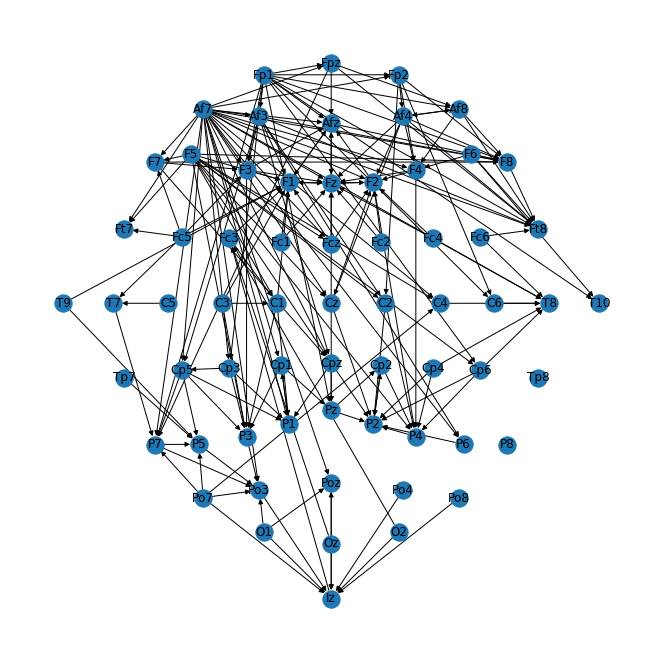

In [77]:
build_graph_3_2(edges,labels,chanel_locations)

In [78]:
len(edges)

193

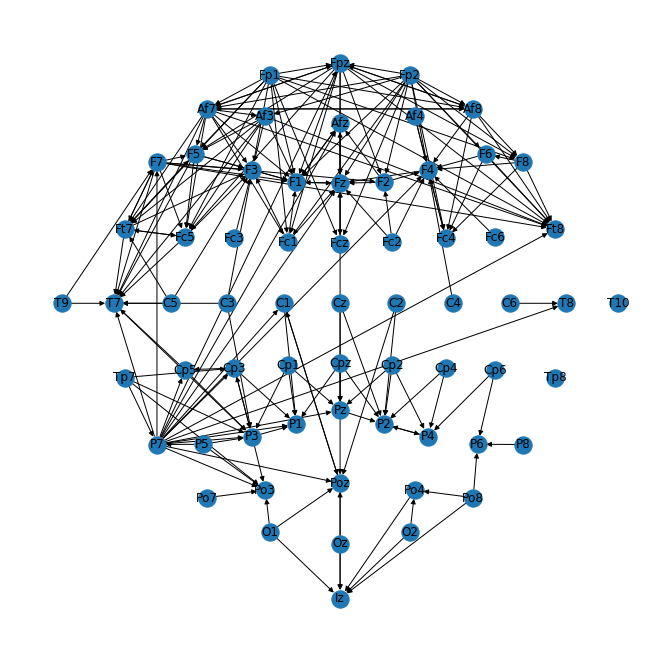

In [79]:
edges2 = func_3_2(graph_1_5_b)
build_graph_3_2(edges2,labels,chanel_locations)

# 3.3

In [80]:
def get_frequence_parieto_occipital(graph,po):
    #pics=[]
    configs = ['A->B->C', 'A->B->C->A','A->B<-C','A->B<-C->A','A<-B->C', 'A<-B->C->A']
    
    conf1,conf2,conf22,conf222,conf_4,conf_5,conf_6 = set(),set(),set(),set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            for th in third_step:
                t = (tuple(sorted(set([node,sec,th]))))
                if (po in t) and th!=node:
                    conf1.add(t)
                if node!=th:
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == sec:
                            fifth = set(graph.successors(fourth))
                            for fi in fifth:
                                if node==fi:
                                    t=(tuple(sorted(set([node,sec,th,fourth,fi]))))
                                    if po in t:conf_6.add(t)
                        if fourth == node :
                            t = (tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t: conf2.add(t)
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:

                                if fif==th:
                                    t= (tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf222.add(t)                            
                                    six = set(graph.successors(fif))
                                    for s in six:
                                        t=(tuple(sorted(set([node,sec,th,fourth,fif,s]))))
                                        if po in t:
                                            conf_4.add(t)
                                        if s==sec:
                                            sev = set(graph.successors(s))
                                            for se in sev:
                                                if se==node:
                                                    t= (tuple(sorted(set([node,sec,th,fourth,fif,s,se]))))
                                                    if po in t:
                                                        conf_5.add(t)
                        if fourth==sec:
                            t= (tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t:
                                conf22.add(t)
    poss_confs={configs[0] : [len(conf1)]}
    poss_confs[configs[1]]=[len(conf2)]
    poss_confs['A->B->C->B']=[len(conf22)]
    poss_confs['A->B->C->A->C']=[len(conf222)]
    poss_confs['A->B->C->A->C->B']=[len(conf_4)]
    poss_confs['A->B->C->A->C->B->A']=[len(conf_5)]
    poss_confs['A->B->C->B->A']=[len(conf_6)]
    
    conf3, conf4, conf44 = set(),set(),set()      
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.predecessors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    t = (tuple(sorted(set([node,sec,th]))))
                    if po in t:
                        conf3.add(t)    
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node:
                            t=(tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t:
                                conf4.add(t)
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif==th:
                                    t=(tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf44.add(t)
    poss_confs[configs[2]]=[len(conf3)]
    poss_confs[configs[3]]=[len(conf4)]
    poss_confs['A->B<-C->A->C']=[len(conf44)]
    
    conf5,conf6,conf7,conf8 = set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.predecessors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    t = (tuple(sorted(set([node,sec,th]))))
                    if po in t:
                        conf5.add(t)
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node and th!=node:
                            #conf6.add((node,sec,th,fourth))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == th:
                                    t = (tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf8.add(t)
                        if fourth==sec and th!=node:
                            t = (tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t:
                                conf7.add(t)
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == node:
                                    t = (tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf6.add(t)
    poss_confs[configs[4]]=[len(conf5)]
    #poss_confs['A<-B->C->B->A']=len(conf6)
    poss_confs['A<-B->C->B']=[len(conf7)]
    poss_confs['A<-B->C->A->C']=[len(conf8)]
    
    return poss_confs#,pics

In [81]:
motif_EO = list(final_counts[final_counts['Z']>1].index)

In [82]:
motif_EO

['A->B->C->B',
 'A->B->C->A->C->B->A',
 'A->B->C->B->A',
 'A->B<-C',
 'A->B<-C->A',
 'A->B<-C->A->C',
 'A<-B->C->A->C']

In [83]:
po8 =  get_frequence_parieto_occipital(graph_DTF_eo,'Po8')
subb={'1':[1]}
for x in motif_EO:
    subb[x]=po8[x]
del subb['1']

In [84]:
subb

{'A->B->C->B': [43],
 'A->B->C->A->C->B->A': [0],
 'A->B->C->B->A': [0],
 'A->B<-C': [369],
 'A->B<-C->A': [45],
 'A->B<-C->A->C': [0],
 'A<-B->C->A->C': [11]}

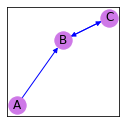

[43]


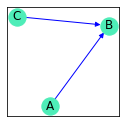

[369]


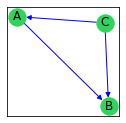

[45]


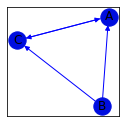

[11]


In [85]:
sub_graphs(subb)

{'A->B->C': [125], 'A->B->C->A': [4], 'A->B->C->B': [53], 'A->B->C->A->C': [4], 'A->B->C->A->C->B': [60], 'A->B->C->A->C->B->A': [0], 'A->B->C->B->A': [2], 'A->B<-C': [186], 'A->B<-C->A': [39], 'A->B<-C->A->C': [4], 'A<-B->C': [62], 'A<-B->C->B': [17], 'A<-B->C->A->C': [20]}


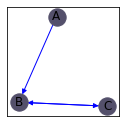

[53]


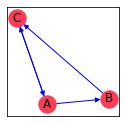

[4]


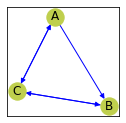

[60]


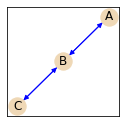

[2]


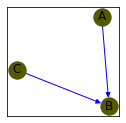

[186]


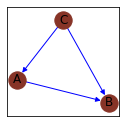

[39]


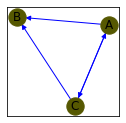

[4]


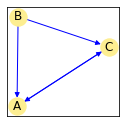

[20]


In [86]:
print(get_frequence_parieto_occipital(graph_DTF_ec,'Po8'))
po8 =  get_frequence_parieto_occipital(graph_DTF_ec,'Po8')
subb={'1':[1]}
motif_EC = list(final_counts2[final_counts2['Z']>1].index)
for x in motif_EC:
    subb[x]=po8[x]
del subb['1']
sub_graphs(subb)

# 4.1 & 4.2
#### Louvian method

In [87]:
chanel_locations['coord']=chanel_locations.apply(lambda row: (row.x,row.y),axis=1)
positions=pd.Series(chanel_locations.coord.values,index=chanel_locations.label).to_dict()
m={k:v for k,v in enumerate(labels)}

In [88]:
def plotCommInfoMap(graph,composition,plt_title):
    g=graph
        
    
    number_of_colors = len(composition.keys())
    palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
 
    color_dict={}
    G = nx.from_edgelist([(names[x[0]], names[x[1]])
                          for names in [g.vs['name']] # simply a let
                          for x in g.get_edgelist()], nx.DiGraph())
    for k,v in composition.items():
        color=palette[k]
        for node in composition[k]:
            if node in G.nodes():
                color_dict[node]=color
    color_map=[color_dict[k] for k in G.nodes()]
        
    plt.figure(3,figsize=(9,9))
    plt.title(plt_title)
    
    nx.draw(G,node_color=color_map,with_labels=True,pos=positions,node_size=450)
    

In [89]:

def callmeMB(gr,file_name=''):
    i_g = igraphGraph(directed=True)
    i_g.add_vertices(list(gr.nodes()))
    i_g.add_edges(gr.edges())
    i_g.vs["name"] = list(gr.nodes())
    
    count_dict=defaultdict(int)
    cl = louvain.find_partition(i_g, louvain.ModularityVertexPartition)

    
    res=dict(zip(i_g.vs["name"],cl.membership))
    for k,v in res.items():
        count_dict[v]+=1

    count_dict2=defaultdict(list)
    for k,v in res.items():
        count_dict2[v].append(k)
    
    fn='louvain_'+file_name
 
     
    df=pd.DataFrame.from_dict(count_dict,orient='index')
    

    
    print('NUMBER OF COMMUNITIES: ',len(count_dict2.keys()))
    print(df,'\n')
    print('Composition of the communities ',count_dict2)
    plotCommInfoMap(i_g,count_dict2,fn)
    return i_g,cl,count_dict2

NUMBER OF COMMUNITIES:  3
    0
1  22
0  22
2  20 

Composition of the communities  defaultdict(<class 'list'>, {1: ['Fc5', 'Fc3', 'C5', 'C3', 'C1', 'C4', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'F7', 'F5', 'Ft7', 'T7', 'T9', 'Tp7', 'P7', 'P5', 'P3', 'P1', 'Pz', 'Po3'], 0: ['Fc1', 'Fcz', 'Fc2', 'Fc4', 'C2', 'C6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft8'], 2: ['Fc6', 'Cz', 'Cp2', 'Cp4', 'Cp6', 'T8', 'T10', 'Tp8', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz']})
Execution time =  0.9003210067749023


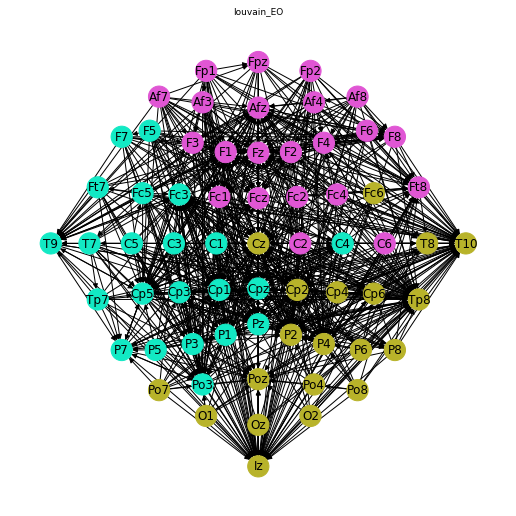

In [90]:
start = time.time()
graph, community,composition = callmeMB(graph_DTF_eo,'EO')
end = time.time()
print('Execution time = ',end-start)

NUMBER OF COMMUNITIES:  4
    0
0  19
1  16
2  15
3  14 

Composition of the communities  defaultdict(<class 'list'>, {0: ['Fc5', 'Fc3', 'Fc1', 'C5', 'C3', 'Fp1', 'Af7', 'Af3', 'F7', 'F5', 'F3', 'F1', 'Ft7', 'T7', 'T9', 'Tp7', 'Tp8', 'P7', 'P3'], 1: ['Fcz', 'Fc2', 'Fc4', 'Fc6', 'Fpz', 'Fp2', 'Afz', 'Af4', 'Af8', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft8', 'T10'], 2: ['C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'T8', 'P2', 'P4'], 3: ['P5', 'P1', 'Pz', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz']})
Execution time =  0.9062740802764893


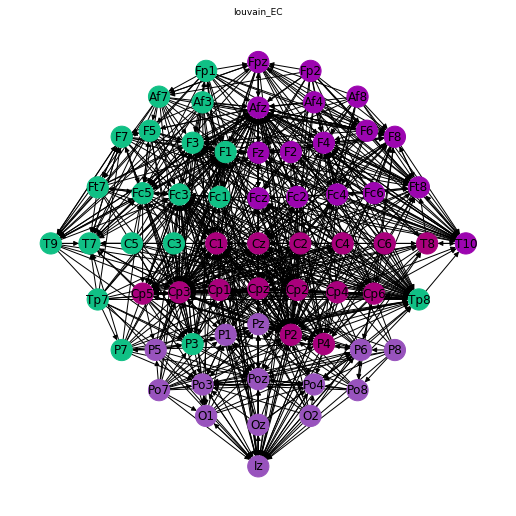

In [91]:
start = time.time()
graph, community,composition = callmeMB(graph_DTF_ec,'EC')
end = time.time()
print('Execution time = ',end-start)

# 4.3

#### Louvian Vs Infomap

In [92]:
from infomap import Infomap
def infomap2(gr,map_dict,file_name):
    
    inv_map={v:k for k,v in map_dict.items()}

    meine_infomap = Infomap("--two-level --directed")
    

 
    for edge in gr.edges():
        meine_infomap.add_link(*edge)

    # Run the Infomap search algorithm to find optimal modules (clusters)
    meine_infomap.run()


  
    node_label=[]
    cluster_label=[]
    for node in meine_infomap.iterTree():
        if node.isLeaf():
           # print("{} {}".format(node.physicalId, node.moduleIndex()))
            node_label.append(inv_map[node.physicalId])
            cluster_label.append(node.moduleIndex())
    res=dict(zip(node_label,cluster_label)) 

    count_dict=defaultdict(int)
    for k,v in res.items():
        count_dict[v]+=1
    ##    print(count_dict)
    count_dict2=defaultdict(list)
    for k,v in res.items():
        count_dict2[v].append(k)
    
    fn='infomap_'+file_name

    df=pd.DataFrame.from_dict(count_dict,orient='index')


    number_of_colors = len(res.keys())
    palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
 
    color_dict={}
    G = nx.relabel_nodes(gr,inv_map)

    for k,v in count_dict2.items():
        color=palette[k]
        for node in count_dict2[k]:
            if node in G.nodes():
                color_dict[node]=color
    color_map=[color_dict[k] for k in G.nodes()]
        
    plt.figure(3,figsize=(9,9))
    plt.title(fn)
    
    nx.draw(G,node_color=color_map,with_labels=True,pos=positions,node_size=450)
    


    
    print('NUMBER OF COMMUNITIES: ', len(count_dict2.keys()))
    print(df,'\n')
    print('Composition of the communities ',count_dict2)


    return res,count_dict2

NUMBER OF COMMUNITIES:  5
    0
0  45
1  10
2   5
3   2
4   2 

Composition of the communities  defaultdict(<class 'list'>, {0: ['T10', 'Iz', 'Cz', 'Tp8', 'P2', 'Cp2', 'Fc3', 'Cp1', 'Poz', 'Cp6', 'P4', 'Cpz', 'Pz', 'Afz', 'Fz', 'Cp5', 'F1', 'Po3', 'P1', 'Ft8', 'Fcz', 'Cp3', 'T9', 'F8', 'C4', 'P7', 'P3', 'T8', 'F2', 'F4', 'Fc1', 'P8', 'Fc2', 'P5', 'F6', 'C3', 'Cp4', 'Fc4', 'Po7', 'C6', 'Fc6', 'O1', 'Oz', 'O2', 'C1'], 1: ['F3', 'Fpz', 'C2', 'Af3', 'F7', 'P6', 'Fp1', 'Fp2', 'Af7', 'F5'], 2: ['T7', 'Tp7', 'Ft7', 'Fc5', 'C5'], 3: ['Po4', 'Po8'], 4: ['Af4', 'Af8']})
Execution time =  0.8069851398468018


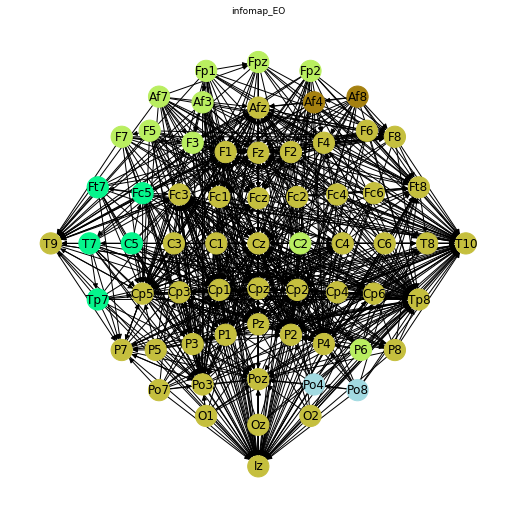

In [93]:
map_dict={}
for i in range(1,len(labels)+1):
    map_dict[labels[i-1]]=i
gr=nx.relabel_nodes(graph_DTF_eo,map_dict)


start = time.time()
cl,count_dict2=infomap2(gr,map_dict,'EO')
end = time.time()
print('Execution time = ',end-start)

NUMBER OF COMMUNITIES:  1
    0
0  64 

Composition of the communities  defaultdict(<class 'list'>, {0: ['Afz', 'Tp8', 'Cp3', 'P2', 'Fc3', 'C1', 'Cp2', 'F1', 'T10', 'Cp5', 'F4', 'F3', 'Iz', 'Cz', 'Poz', 'P4', 'Ft8', 'Fcz', 'Fz', 'Pz', 'F8', 'P1', 'Cpz', 'P3', 'Fc5', 'Po4', 'Po3', 'T7', 'Cp6', 'Fc4', 'Cp1', 'Fc1', 'T8', 'P6', 'C2', 'T9', 'C4', 'F6', 'F5', 'Fpz', 'O1', 'Fc2', 'F7', 'F2', 'P5', 'Fp1', 'Oz', 'Ft7', 'Po8', 'Af7', 'P7', 'Tp7', 'Af4', 'Af3', 'Fp2', 'P8', 'Po7', 'Cp4', 'Fc6', 'O2', 'Af8', 'C5', 'C3', 'C6']})
Execution time =  0.8905589580535889


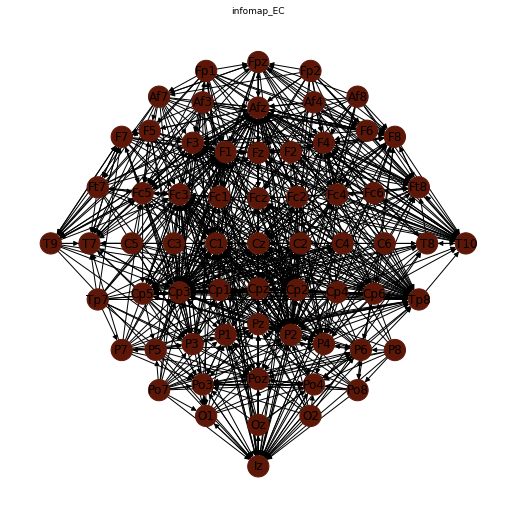

In [94]:
gr=nx.relabel_nodes(graph_DTF_ec,map_dict)
start = time.time()
cl,count_dict2=infomap2(gr,map_dict,'EC')
end = time.time()
print('Execution time = ',end-start)